In [7]:
import numpy as np
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits

### Dataset = [Optical recognition of handwritten digits dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset)
In this exercise, we want to recognize
handwritten digits, which is a typical machine learning application. The dataset digits consists of
1797 small images with one digit per image.

In [5]:
digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


### What is the size of the images?

In [44]:
data

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [10]:
data.shape

(1797, 64)

The data is a flattened vector of the 8x8 pixel 16 bit images, hence the length of 64.

### Visualize one image of a 3 using the imshow function from matplotlib.pyplot, trying the two interpolation methods in the code:

In [42]:
target

array([0, 1, 2, ..., 8, 9, 8])

In [26]:
np.where(target == 3)[0][0]

3

In [41]:
img = data[[3]]

assert len(img.shape) == 2

print(img)

[[ 0.  0.  7. 15. 13.  1.  0.  0.  0.  8. 13.  6. 15.  4.  0.  0.  0.  2.
   1. 13. 13.  0.  0.  0.  0.  0.  2. 15. 11.  1.  0.  0.  0.  0.  0.  1.
  12. 12.  1.  0.  0.  0.  0.  0.  1. 10.  8.  0.  0.  0.  8.  4.  5. 14.
   9.  0.  0.  0.  7. 13. 13.  9.  0.  0.]]


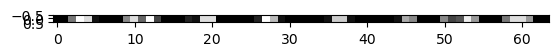

In [49]:
plt.figure()
plt.gray()
plt.imshow(img , interpolation = "nearest")
plt.show()

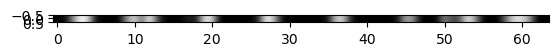

In [50]:
plt.figure()
plt.gray()
plt.imshow(img , interpolation = "bicubic")
plt.show()

We will only work with digits "3" and "9" to get a two-class problem. Please filter the dataset such
that only these two digits are left. Split this filtered dataset in a training and a test set (#train/#test
= 3/2)

In [79]:
from sklearn import model_selection
X_filtered = data[target == 3]
y_filtered = target[target == 3]

X_train , X_test , y_train , y_test = \
    model_selection.train_test_split(X_filtered, y_filtered, test_size = 0.4, random_state = 0)